In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

from pytket.extensions.cutensornet.mps import (
    CuTensorNetHandle,
    ConfigMPS,
    ContractionAlg,
    simulate, 
    prepare_circuit
)

# Introduction

This notebook provides examples of the usage of the MPS functionalities of `pytket_cutensornet`. For more information, see the docs at https://tket.quantinuum.com/extensions/pytket-cutensornet/api/index.html.

A Matrix Product State (MPS) represents a state on `n` qubits as a list of `n` tensors connected in a line as show below:

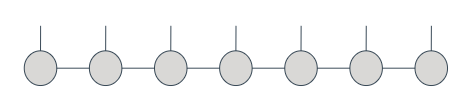

Each of these circles corresponds to a tensor. We refer to each leg of a tensor as a *bond* and the number of bonds a tensor has is its *rank*. In code, a tensor is just a multidimensional array:
```
    tensor[i][j][k] = v
```
In the case above, we are assigning an entry value `v` of a rank-3 tensor (one `[ ]` coordinate per bond). Each bond allows a different number of values for its indices; for instance `0 <= i < 4` would mean that the first bond of our tensor can take up to four different indices; we refer to this as the *dimension* of the bond. We refer to the bonds connecting different tensors in the MPS as *virtual bonds*; the maximum allowed value for the dimension of virtual bonds is often denoted by the greek letter `chi`. The open bonds are known as *physical bonds* and, in our case, each will correspond to a qubit; hence, they have dimension `2` -- the dimension of the vector space of a single qubit. 

In essence, whenever we want to apply a gate to certain qubit we will connect a tensor (matrix) representing the gate to the corresponding physical bond and *contract* the network back to an MPS form (tensor contraction is a generalisation of matrix multiplication to multidimensional arrays). Whenever a two-qubit gate is applied, the entanglement information after contraction will be kept in the degrees of freedom of the virtual bonds. As such, the dimension of the virtual bonds will generally increase exponentially as we apply entangling gates, leading to large memory footprints of the tensors and, consequently, long runtime for tensor contraction. We provide functionalities to limit the growth of the dimension of the virtual bonds, keeping resource consumption in check. Read the *Approximate simulation* section on this notebook to learn more.

**NOTE**: MPS methods can only be applied to circuits that only contain gates that act between nearest-neighbours in a line. If your circuit does not satisfy this constraint, you can use the `prepare_circuit` function (see the *Preparing the circuit* section); this will add multiple `SWAP` gates to the circuit that *need* to be simulated explicitly within the MPS, increasing the resources required considerably. In the future, we will support other tensor network state approaches that do not suffer so drastically from this restrictive connectivity.

**References**: To read more about MPS we recommend the following papers.
* For an introduction to MPS and its canonical form: https://arxiv.org/abs/1901.05824.
* For a description of the `MPSxGate` algorithm we provide: https://arxiv.org/abs/2002.07730.
* For a description of the `MPSxMPO` algorithm we provide: https://arxiv.org/abs/2207.05612.
* For insights on the reationship between truncation error and the error model in a quantum computer: https://arxiv.org/abs/2004.02388

# Basic functionality and exact simulation

Here we show an example of the basic use of our MPS methods. We first generate a simple `pytket` circuit to be simulated.

In [2]:
my_circ = Circuit(5)
my_circ.CX(3, 4)
my_circ.H(2)
my_circ.CZ(0, 1)
my_circ.ZZPhase(0.1, 4, 3)
my_circ.TK2(0.3, 0.5, 0.7, 2, 1)
my_circ.Ry(0.2, 0)

render_circuit_jupyter(my_circ)

For **exact** simulation, simply call the `simulate` function on the circuit and choose a contraction algorithm. To learn more about the contraction algorithms we provide see the *Contraction algorithms* section of this notebook. You will also need to provide a configuration, the default one is provided by `ConfigMPS()`. Custom settings of `ConfigMPS` are discussed in the *Approximate simulation* section.

**NOTE**: whenever you wish to generate an `MPS` object or execute calculations on it you must do so within a `with CuTensorNetHandle() as libhandle:` block; this will initialise the cuTensorNetwork library for you, and destroy its handles at the end of the `with` block. You will need to pass the `libhandle` to the `MPS` object via the method that generates it (in the snippet below, `simulate`), or if already initialised, pass it via the `update_libhandle` method.

Due to the nature of Jupyter notebooks, we will be starting most of these cells with a `with CuTensorNetHandle() as libhandle:`. However, in a standard script, all of these cells would be grouped together and a single `with CuTensorNetHandle() as libhandle:` statement would be necessary at the beginning of the script.

In [3]:
with CuTensorNetHandle() as libhandle:
    my_mps = simulate(libhandle, my_circ, ContractionAlg.MPSxGate, ConfigMPS())

Notice that `my_circ` uses a rich gateset -- in fact, every single-qubit and two-qubit gate supported by `pytket` can be used in our MPS approaches. Gates acting on more than two qubits are not currently supported.

The output of `simulate` is an `MPS` object encoding the output state of the circuit. Currently we support two basic operations on `MPS` objects: obtaining amplitudes of computational states and calculating inner products with other `MPS` objects. More functionality (including sampling from the measurement distribution of the state) will come in due course.

### Obtain an amplitude from an MPS

Let's first see how to get the amplitude of the state `|10100>` from the output of the previous circuit.

In [4]:
state = int('10100', 2)
with CuTensorNetHandle() as libhandle:
    my_mps.update_libhandle(libhandle)
    amplitude = my_mps.get_amplitude(state)
print(amplitude)

(0.03968884089773739+0.05462700305610267j)


Since this is a very small circuit, we can use `pytket`'s state vector simulator capabilities to verify that the state is correct by checking the amplitude of each of the computational states.

In [5]:
state_vector = my_circ.get_statevector()
n_qubits = len(my_circ.qubits)

correct_amplitude = [False] * (2**n_qubits)
with CuTensorNetHandle() as libhandle:
    my_mps.update_libhandle(libhandle)
    for i in range(2**n_qubits):
        correct_amplitude[i] = np.isclose(state_vector[i], my_mps.get_amplitude(i))

print("Are all amplitudes correct?")
print(all(correct_amplitude))

Are all amplitudes correct?
True


### Sampling from an MPS

We can also sample from the output state of a circuit by calling `my_mps.sample`, where `my_mps` is the outcome of simulating the circuit.

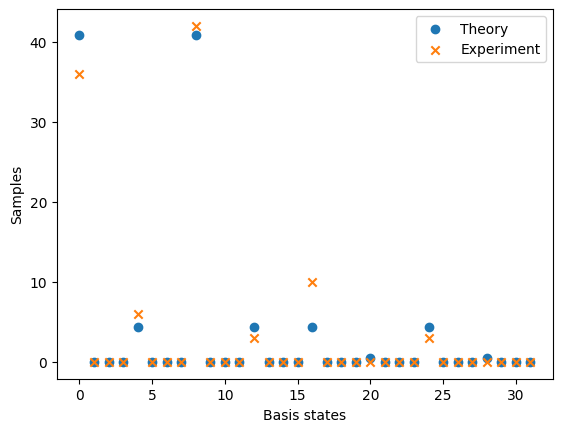

In [6]:
n_samples = 100
n_qubits = len(my_circ.qubits)

# Initialise the sample counter
sample_count = [0 for _ in range(2**n_qubits)]

with CuTensorNetHandle() as libhandle:
    my_mps.update_libhandle(libhandle)
    
    for _ in range(n_samples):
        # Draw a sample
        qubit_outcomes = my_mps.sample()
        # Convert qubit outcomes to bitstring
        bitstring = "".join(str(qubit_outcomes[q]) for q in my_circ.qubits)
        # Convert bitstring to int
        outcome = int(bitstring, 2)
        # Update the sample dictionary
        sample_count[outcome] += 1
        
# Calculate the theoretical number of samples per bitstring
expected_count = [n_samples*abs(state_vector[i])**2 for i in range(2**n_qubits)]
        
# Plot a comparison of theory vs sampled
plt.scatter(range(2**n_qubits), expected_count, label="Theory")
plt.scatter(range(2**n_qubits), sample_count, label="Experiment", marker='x')
plt.xlabel("Basis states")
plt.ylabel("Samples")
plt.legend()
plt.show()

We also provide methods to apply mid-circuit measurements via `my_mps.measure(qubits)` and postselection via `my_mps.postselect(qubit_outcomes)`. Their use is similar to that of `my_mps.sample()` shown above.

**Note:** whereas `my_mps.sample()` does *not* change the state of the MPS, `my_mps.measure(qubits)` and `my_mps.postselect(qubit_outcomes)` do change it, projecting the state to the resulting outcome and removing the measured qubits.

### Inner products

Using `vdot` you can obtain the inner product of two states in MPS form. This method does not change the internal data of neither of the MPS. Moreover, it can be used on the same `MPS` object for both inputs, yielding the squared norm of the state.

In [7]:
with CuTensorNetHandle() as libhandle:
    my_mps.update_libhandle(libhandle)
    norm_sq = my_mps.vdot(my_mps)

print("As expected, the squared norm of a state is 1")
print(np.isclose(norm_sq, 1))

As expected, the squared norm of a state is 1
True


Let's come up with another circuit on the same qubits and apply an inner product between the two `MPS` objects.

In [8]:
# Generate circuits
other_circ = Circuit(5)
other_circ.H(3)
other_circ.CZ(3, 4)
other_circ.XXPhase(0.3, 1, 2)
other_circ.Ry(0.7, 3)

# Simulate them
with CuTensorNetHandle() as libhandle:
    other_mps = simulate(libhandle, other_circ, ContractionAlg.MPSxGate, ConfigMPS())

Let's calculate the inner product and check that it agrees with `pytket`'s state vector based computation.

In [9]:
with CuTensorNetHandle() as libhandle:
    my_mps.update_libhandle(libhandle)
    inner_product = my_mps.vdot(other_mps)
    
my_state = my_circ.get_statevector()
other_state = other_circ.get_statevector()

print("Is the inner product correct?")
print(np.isclose(np.vdot(my_state, other_state), inner_product))

Is the inner product correct?
True


### Preparing the circuit

If the circuit to be simulated contains gates that do not act between nearest neighbour qubits, an error message will be raised.

In [10]:
bad_circ = Circuit(5)
bad_circ.H(1)
bad_circ.ZZPhase(0.3, 2, 3)
bad_circ.CX(0, 1)
bad_circ.Ry(0.8, 4)
bad_circ.CZ(3, 4)
bad_circ.XXPhase(0.7, 1, 2)
bad_circ.TK2(0.1, 0.2, 0.4, 1, 4)

render_circuit_jupyter(bad_circ)

In [11]:
with CuTensorNetHandle() as libhandle:
    try:
        simulate(libhandle, bad_circ, ContractionAlg.MPSxGate, ConfigMPS())
    except RuntimeError as e:
        print(e)

('Some two-qubit gate in the circuit is not acting between', 'nearest neighbour qubits. Consider using prepare_circuit().')


As suggested by the error message, we can call `prepare_circuit` to use `pytket` routing capabilities to guarantee that the circuit can be run using our MPS approaches.

In [12]:
prep_circ, qubit_map = prepare_circuit(bad_circ)
render_circuit_jupyter(prep_circ)
# Print the correspondence between qubit names in `prep_circuit` and the original qubits from `circuit` at the output
print(qubit_map)

{node[4]: q[0], node[1]: q[1], node[3]: q[2], node[2]: q[3], node[0]: q[4]}


The circuit can now be simulated as usual.

In [13]:
with CuTensorNetHandle() as libhandle:
    prep_mps = simulate(libhandle, prep_circ, ContractionAlg.MPSxGate, ConfigMPS())
    print("Did simulation succeed?")
    print(prep_mps.is_valid())

Did simulation succeed?
True


# Approximate simulation

We provide two policies for approximate simulation; these are supported by both of our current MPS contraction algorithms:

* Bound the maximum value of the virtual bond dimension `chi`. If a bond dimension would increase past that point, we *truncate* (i.e. discard) the degrees of freedom that contribute the least to the state description. We can keep track of a lower bound of the error that this truncation causes.
* Provide a value for acceptable two-qubit gate fidelity `truncation_fidelity`. After each two-qubit gate we truncate the dimension of virtual bonds as much as we can while guaranteeing the target gate fidelity. The more fidelity you require, the longer it will take to simulate. **Note**: this is *not* the final fidelity of the output state, but the fidelity per gate.

Values for `chi` and `truncation_fidelity` can be set via `ConfigMPS`. To showcase approximate simulation, let's define a circuit where exact MPS contraction starts struggling.

In [14]:
def random_line_circuit(n_qubits: int, layers: int) -> Circuit:
    """Random circuit with line connectivity."""
    c = Circuit(n_qubits)

    for i in range(layers):
        # Layer of TK1 gates
        for q in range(n_qubits):
            c.TK1(np.random.rand(), np.random.rand(), np.random.rand(), q)

        # Layer of CX gates
        offset = np.mod(i, 2)  # Even layers connect (q0,q1), odd (q1,q2)
        qubit_pairs = [
            [c.qubits[i], c.qubits[i + 1]] for i in range(offset, n_qubits - 1, 2)
        ]
        # Direction of each CX gate is random
        for pair in qubit_pairs:
            np.random.shuffle(pair)

        for pair in qubit_pairs:
            c.CX(pair[0], pair[1])

    return c

In [15]:
circuit = random_line_circuit(n_qubits = 20, layers = 20)

For exact contraction, `chi` must be allowed to be up to `2**(n_qubits // 2)`, meaning that if we set `n_qubits = 20` it would require `chi = 1024`; already too much for this particular circuit to be simulated in a gaming laptop using the current implementation. Instead, let's bound `chi` to a maximum of `16`. Doing so results in faster runtime, at the expense of losing output state fidelity.

In [16]:
start = time()
with CuTensorNetHandle() as libhandle:
    config = ConfigMPS(chi=16)
    bound_chi_mps = simulate(libhandle, circuit, ContractionAlg.MPSxGate, config)
end = time()
print("Time taken by approximate contraction with bound chi:")
print(f"{round(end-start,2)} seconds")
print("\nLower bound of the fidelity:")
print(round(bound_chi_mps.fidelity, 4))

Time taken by approximate contraction with bound chi:
1.89 seconds

Lower bound of the fidelity:
0.3742


Alternatively, we can fix `truncation_fidelity` and let `chi` increase as necessary to satisfy it.

In [17]:
start = time()
with CuTensorNetHandle() as libhandle:
    config = ConfigMPS(truncation_fidelity=0.999)
    fixed_fidelity_mps = simulate(libhandle, circuit, ContractionAlg.MPSxGate, config)
end = time()
print("Time taken by approximate contraction with fixed truncation fidelity:")
print(f"{round(end-start,2)} seconds")
print("\nLower bound of the fidelity:")
print(round(fixed_fidelity_mps.fidelity, 4))

Time taken by approximate contraction with fixed truncation fidelity:
2.89 seconds

Lower bound of the fidelity:
0.9298


# Contraction algorithms

We currently offer two MPS-based simulation algorithms:
    
* **MPSxGate**: Apply gates one by one to the MPS, canonicalising the MPS and truncating when necessary. In particular, we implemented the algorithm from the following paper: https://arxiv.org/abs/2002.07730.
* **MPSxMPO**: Maintain two MPS copies of the state as it evolves, one updated eagerly using the **MPSxGate** method and the other updated in batches of up to `k` layers of two-qubit gates. Whenever the second MPS is updated, both copies are synchronised and an optimisation algorithm is applied to increase the fidelity of the state. This algorithm is often referred to as DMRG-like simulation. In particular, we implemented the algorithm from the following paper: https://arxiv.org/abs/2207.05612.

The `MPSxGate` algorithm is the one we have been using for all of the examples above. In comparison, the `MPSxMPO` algorithm provides the user with two new parameters to tune:

* **k**: The maximum number of layers the MPO is allowed to have before being contracted. Increasing this might increase fidelity, but it will also increase resource requirements exponentially. Default value is `4`.
* **optim_delta**: Stopping criteria for the optimisation when contracting the `k` layers of MPO. Stops when the increase of fidelity between iterations is smaller than `optim_delta`. Default value is `1e-5`.

Both `k` and `optim_delta` can be set via `ConfigMPS`. Below we compare `MPSxGate` versus `MPSxMPO` with default parameters and `MPSxMPO` with more resource-hungry parameters. The circuit used is the same as in the previous section.

In [18]:
start = time()
with CuTensorNetHandle() as libhandle:
    config = ConfigMPS(chi=16)
    fixed_fidelity_mps = simulate(libhandle, circuit, ContractionAlg.MPSxGate, config)
end = time()
print("MPSxGate")
print(f"\tTime taken: {round(end-start,2)} seconds")
print(f"\tLower bound of the fidelity: {round(fixed_fidelity_mps.fidelity, 4)}")

MPSxGate
	Time taken: 1.89 seconds
	Lower bound of the fidelity: 0.3712


In [19]:
start = time()
with CuTensorNetHandle() as libhandle:
    config = ConfigMPS(chi=16)
    fixed_fidelity_mps = simulate(libhandle, circuit, ContractionAlg.MPSxMPO, config)
end = time()
print("MPSxMPO, default parameters")
print(f"\tTime taken: {round(end-start,2)} seconds")
print(f"\tLower bound of the fidelity: {round(fixed_fidelity_mps.fidelity, 4)}")

MPSxMPO, default parameters
	Time taken: 27.17 seconds
	Lower bound of the fidelity: 0.3956


In [20]:
start = time()
with CuTensorNetHandle() as libhandle:
    config = ConfigMPS(k=8, optim_delta=1e-15, chi=16)
    fixed_fidelity_mps = simulate(libhandle, circuit, ContractionAlg.MPSxMPO, config)
end = time()
print("MPSxMPO, custom parameters")
print(f"\tTime taken: {round(end-start,2)} seconds")
print(f"\tLower bound of the fidelity: {round(fixed_fidelity_mps.fidelity, 4)}")

MPSxMPO, custom parameters
	Time taken: 26.99 seconds
	Lower bound of the fidelity: 0.4209


**Note**: `MPSxMPO` also admits truncation policy in terms of `truncation_fidelity` instead of `chi`.

# Using the logger

You can request a verbose log to be produced during simulation, by assigning the `loglevel` argument when creating a `ConfigMPS` instance. Currently, two log levels are supported (other than default, which is silent): 
- `logging.INFO` will print information about progress percent, memory currently occupied by the MPS and current fidelity. Additionally, some high level information of the current stage of the simulation is provided, such as when `MPSxMPO` is applying optimisation sweeps.
- `logging.DEBUG` provides all of the messages from the loglevel above plus detailed information of the current operation being carried out and the values of important variables.

**Note**: Due to technical issues with the `logging` module and Jupyter notebooks we need to reload the `logging` module. When working with python scripts and command line, just doing `import logging` is enough.

In [21]:
from importlib import reload  # Not needed in Python 2
import logging
reload(logging)

<module 'logging' from '/global/homes/p/pam_q/.conda/envs/py-cuquantum-23.06.0-mypich-py3.9/lib/python3.9/logging/__init__.py'>

An example of the use of `logging.INFO` is provided below. 

In [22]:
with CuTensorNetHandle() as libhandle:
    config = ConfigMPS(truncation_fidelity=0.999, loglevel=logging.INFO)
    simulate(libhandle, circuit, ContractionAlg.MPSxMPO, config)

[15:41:45] Simulation (INFO) - Ordering the gates in the circuit to reduce canonicalisation overhead.
[15:41:45] Simulation (INFO) - Running simulation...
[15:41:45] Simulation (INFO) - Progress... 0%
[15:41:45] Simulation (INFO) - Progress... 0%
[15:41:45] Simulation (INFO) - Progress... 0%
[15:41:45] Simulation (INFO) - Progress... 0%
[15:41:45] Simulation (INFO) - Progress... 0%
[15:41:45] Simulation (INFO) - Progress... 0%
[15:41:45] Simulation (INFO) - Progress... 1%
[15:41:45] Simulation (INFO) - Progress... 1%
[15:41:45] Simulation (INFO) - Progress... 1%
[15:41:45] Simulation (INFO) - Progress... 1%
[15:41:45] Simulation (INFO) - Progress... 1%
[15:41:45] Simulation (INFO) - Progress... 1%
[15:41:45] Simulation (INFO) - Progress... 2%
[15:41:45] Simulation (INFO) - Progress... 2%
[15:41:45] Simulation (INFO) - Progress... 2%
[15:41:45] Simulation (INFO) - Progress... 2%
[15:41:45] Simulation (INFO) - Progress... 2%
[15:41:45] Simulation (INFO) - Progress... 2%
[15:41:45] Simula